In [103]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import gc
import os
import glob

In [2]:
os.getcwd()

'C:\\Users\\ZM\\Desktop'

In [102]:
print("GPU:", tf.config.list_physical_devices('GPU'), "\nCUDA Enabled:", tf.test.is_built_with_cuda(), "\nGPU Name:", tf.test.gpu_device_name(), "\nVisible Devices:", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

GPU: [] 
CUDA Enabled: True 
GPU Name:  
Visible Devices: []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6330907279845180667
]


# Wafer Maps

In [3]:
%matplotlib inline

path = os.path.join(os.getcwd(), 'klarf-map')
imgs = sorted(os.listdir(path))
# for i in range(len(imgs)):
i=76
print(imgs[i])

img_array = cv2.imread(os.path.join(path, imgs[i]))#, cv2.IMREAD_GRAYSCALE)

result = img_array.copy()
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2HSV)

lower1 = np.array([0,180,20])
upper1 = np.array([25,255,255])

lower2 = np.array([160,180,20])
upper2 = np.array([180,255,255])

mask1 = cv2.inRange(img_array, lower1, upper1)
mask2 = cv2.inRange(img_array, lower2, upper2)
mask = cv2.bitwise_or(mask1, mask2)

result[mask == 255] = (255, 255, 255)

result = cv2.bitwise_and(result, result, mask=mask)
# result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)

# cv2_imshow(mask)
cv2.imshow('result', result)

img_array = cv2.cvtColor(img_array, cv2.COLOR_HSV2BGR)
cv2.imshow('img', img_array)
cv2.waitKey()

wafer-5359.jpg


-1

# Edge Normal

---

With sigmoid + binary cross entropy the final dense layer should have 1 node

In [115]:
NUM_CLASSES = 2
SEED = 69
IMG_SIZE = 256
BATCH_SIZE = 8
VAL_SPLIT = 0.2

DEFECT_LIST = ['none', 'chipping']
DEFECT_MAPPING = {DEFECT_LIST[i]:i for i in range(len(DEFECT_LIST))}

In [86]:
import time, datetime, pytz

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras import layers

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [87]:
EN_path = os.path.join(os.getcwd(), 'klarf-EN')

In [105]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
#     fill_mode='constant',
    cval=255,
    validation_split=VAL_SPLIT # set validation split
)

train_generator = train_datagen.flow_from_directory(
    EN_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=DEFECT_LIST,
    color_mode='rgb',
    shuffle=True,
    seed=SEED,
#     save_to_dir=os.path.join(os.getcwd(), 'augmented-EN'),
    subset='training'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT # set validation split
)

val_generator = val_datagen.flow_from_directory(
    EN_path, # same directory as training data
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=DEFECT_LIST,
    color_mode='rgb',
    shuffle=False,
    seed=SEED,
    subset='validation' # set as validation data
)

Found 2038 images belonging to 2 classes.
Found 226 images belonging to 2 classes.


In [89]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [90]:
class_weights

{0: 0.5067130780706116, 1: 37.74074074074074}

In [108]:
# model configs
CONV_LAYERS = 4

CONV_KERNEL_SIZE = (3,3)
POOL_KERNEL_SIZE = (2,2)

CONV_LAYER_SIZE = 32 # 32
DENSE_LAYER_SIZE = 128 # 64

CONV_PADDING = 'same' # valid / same
FINAL_CONV = 'max' # max / avg / g_avg

DROPOUT = 0.5

# hyperparams
EPOCHS = 20

# optimizers
lr = 1e-3
sgd = SGD()
adam = Adam(learning_rate=lr) # 1e-3
adadelta = Adadelta() # bad
rmsprop = RMSprop() # 1e-4

OPTIMIZER = adam
OPTIMIZER_NAME = str(OPTIMIZER).split(' ')[0].split('.')[-1]

In [109]:
#--- CNN MODEL ---#
model = Sequential()

#--- Data Aug ---#
# model.add(RandomFlip())
# model.add(RandomRotation(0.2))

#--- Input Layer ---#
model.add(Conv2D(CONV_LAYER_SIZE, CONV_KERNEL_SIZE, input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu', padding=CONV_PADDING, kernel_initializer = 'he_uniform'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(POOL_KERNEL_SIZE))

#--- Hidden Layers ---#
for i in range(CONV_LAYERS-1):
    model.add(Conv2D(CONV_LAYER_SIZE*2**i, CONV_KERNEL_SIZE, activation='relu', padding=CONV_PADDING, kernel_initializer = 'he_uniform'))
    
    if i != CONV_LAYERS-2:
        model.add(MaxPooling2D(pool_size=POOL_KERNEL_SIZE))
    else: # Set Final Conv Layer
        if FINAL_CONV == 'max': model.add(MaxPooling2D(pool_size=POOL_KERNEL_SIZE))
        elif FINAL_CONV == 'avg': model.add(AveragePooling2D(pool_size=POOL_KERNEL_SIZE))
        elif FINAL_CONV == 'g_avg': model.add(GlobalAveragePooling2D())
        # model.add(Dropout(0.1))
        # model.add(BatchNormalization())

#--- Output Layer ---#
model.add(Flatten())
model.add(Dense(DENSE_LAYER_SIZE, activation='relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(1, activation='sigmoid'))

#--- MODEL CALLBACKS ---#
DATETIME = datetime.datetime.now(pytz.timezone('Asia/Singapore')).strftime('%#d%b-%H%M')
NAME = f"{CONV_LAYERS}x{CONV_LAYER_SIZE}-{CONV_KERNEL_SIZE}_{DROPOUT}drop_{EPOCHS}ep_{OPTIMIZER_NAME}_[{DATETIME}]"

tensorboard = TensorBoard(log_dir=f"logs/{NAME}") # tensorboard --log_dir=logs/
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(f'drive/MyDrive/SSMC/models/{NAME}_BEST.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lr_stagnate = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6, verbose=1, mode='auto')

def scheduler(epoch, lr):
    if epoch == 15:
        return lr / 5
    elif epoch == 30 or epoch == 40:
        return lr / 2
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

CALLBACKS = [tensorboard]#, checkpoint, lr_stagnate, earlystop]
CALLBACK_NAMES = [f'{str(c).split(" ")[0].split(".")[-1]}' for c in CALLBACKS]

#--- MODEL COMPILE ---#
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

#--- MODEL FIT ---#
start = time.time()
print(f'// {NAME}')

hist = model.fit(train_generator, validation_data=val_generator, batch_size=BATCH_SIZE, epochs=EPOCHS, class_weight=class_weights, callbacks=CALLBACKS)

DURATION = round((time.time() - start)/60, 2)
print(f'\n{DURATION} mins')

#--- Cleanup Ram ---#
gc.collect()

// 4x32-(3, 3)_0.5drop_20ep_Adam_[1Oct-1525]
Epoch 1/20
255/255 [==============================] - 103s 402ms/step - loss: 18.9805 - accuracy: 0.8047 - val_loss: 0.7743 - val_accuracy: 0.0442
Epoch 2/20
255/255 [==============================] - 105s 410ms/step - loss: 10.7813 - accuracy: 0.4980 - val_loss: 1.0506 - val_accuracy: 0.0133
Epoch 3/20
255/255 [==============================] - 109s 426ms/step - loss: 2.9524 - accuracy: 0.3871 - val_loss: 0.6006 - val_accuracy: 0.9381
Epoch 4/20
255/255 [==============================] - 103s 404ms/step - loss: 0.7457 - accuracy: 0.4235 - val_loss: 0.8149 - val_accuracy: 0.1814
Epoch 5/20
255/255 [==============================] - 95s 373ms/step - loss: 0.6869 - accuracy: 0.2767 - val_loss: 0.6652 - val_accuracy: 0.5708
Epoch 6/20
255/255 [==============================] - 105s 412ms/step - loss: 0.6875 - accuracy: 0.2542 - val_loss: 0.7435 - val_accuracy: 0.3230
Epoch 7/20
255/255 [==============================] - 108s 425ms/step - loss: 

20206

In [19]:
%tensorboard --logdir logs

In [110]:
y_test = val_generator.classes
y_pred = np.rint(model.predict(val_generator)).flatten()

In [111]:
y_pred

array([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0.

In [112]:
accuracy = (y_test == y_pred).sum() / y_test.size
TP = ((y_test == 1) & (y_pred == 1)).sum()
FP = ((y_test == 0) & (y_pred == 1)).sum()
TN = ((y_test == 0) & (y_pred == 0)).sum()
FN = ((y_test == 0) & (y_pred == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP+FN)

In [113]:
accuracy, TP, FP, precision, recall

(0.7123893805309734, 0, 62, 0.0, 0.0)

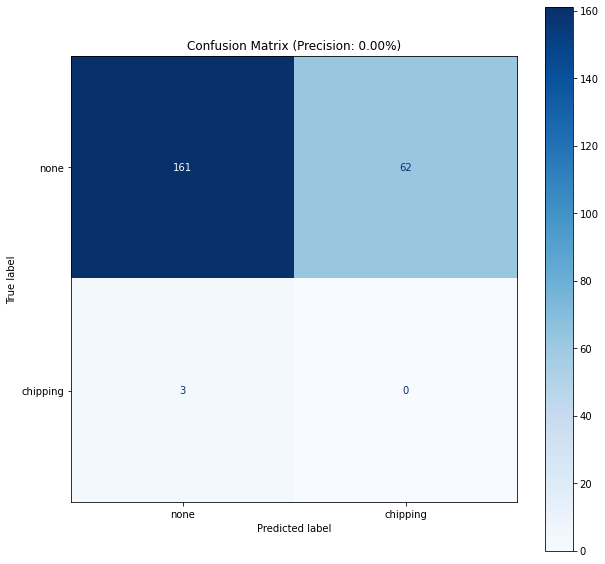

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, np.rint(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DEFECT_LIST)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'Confusion Matrix (Precision: {precision:.2%})')

disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

# Random Forest

In [ ]:
feature_extractor = VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features # This is our X input to RF

In [ ]:
X_for_RF.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train_encoded) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [ ]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
from sklearn import metrics
print (f'Accuracy = {metrics.accuracy_score(y_test, prediction_RF):.2%}')

In [ ]:
prediction_RF

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
n = np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature = VGG_model.predict(input_img)
input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0]
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", y_test[n])